In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler


In [2]:
from google.colab import files
 
 
uploaded = files.upload()

Saving ASELSAN-2017-2022.csv to ASELSAN-2017-2022.csv


In [3]:
import io
df = pd.read_csv(io.BytesIO(uploaded['ASELSAN-2017-2022.csv']))
# Dataset is now stored in a Pandas Dataframe

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-06-15,11.00,11.06,10.92,11.03,10.695765,7122628
1,2017-06-16,11.03,11.08,10.92,10.92,10.589099,7462226
2,2017-06-19,10.95,10.97,10.90,10.90,10.569703,4526662
3,2017-06-20,10.92,10.97,10.84,10.85,10.521218,4386578
4,2017-06-21,10.86,11.04,10.77,10.99,10.656976,9809562


In [5]:
df = df[['Date', 'Adj Close']]


In [6]:
df.head()

,Date,Adj Close
0,2017-06-15,10.695765
1,2017-06-16,10.589099
2,2017-06-19,10.569703
3,2017-06-20,10.521218
4,2017-06-21,10.656976


In [7]:
df.tail()

,Date,Adj Close
1272,2022-06-08,23.379999
1273,2022-06-09,23.700001
1274,2022-06-10,23.240000
1275,2022-06-13,22.799999
1276,2022-06-14,23.280001


In [8]:
df.dtypes

Date          object
Adj Close    float64
dtype: object

In [9]:
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
df.dtypes

Date         datetime64[ns]
Adj Close           float64
dtype: object

In [11]:
df["Date"]= pd.to_datetime(df['Date'], utc=False)

In [12]:
df.dtypes

Date         datetime64[ns]
Adj Close           float64
dtype: object

In [13]:
df.head()

,Date,Adj Close
0,2017-06-15,10.695765
1,2017-06-16,10.589099
2,2017-06-19,10.569703
3,2017-06-20,10.521218
4,2017-06-21,10.656976


In [14]:
df.index = df['Date']

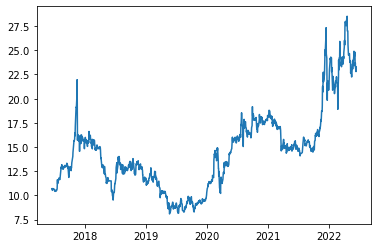

In [15]:
plt.plot(df["Adj Close"],label='Date')

In [16]:
df = df.sort_index(ascending=True,axis=0)
data = pd.DataFrame(index=range(0,len(df)),columns=['Date','Adj Close'])
for i in range(0,len(data)):
    data["Date"][i]=df['Date'][i]
    data["Adj Close"][i]=df["Adj Close"][i]
data.head()

,Date,Adj Close
0,2017-06-15 00:00:00,10.695765
1,2017-06-16 00:00:00,10.589099
2,2017-06-19 00:00:00,10.569703
3,2017-06-20 00:00:00,10.521218
4,2017-06-21 00:00:00,10.656976


In [17]:
data["Date"]= pd.to_datetime(data['Date'], utc=False)

In [18]:
data.shape

(1277, 2)

In [19]:
scaler=MinMaxScaler(feature_range=(0,1))
data.index=data.Date
data.drop("Date",axis=1,inplace=True)
final_data = data.values
train_data=final_data[0:200,:]
valid_data=final_data[200:,:]
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_data)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

In [20]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(np.shape(x_train_data)[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
model_data=data[len(data)-len(valid_data)-60:].values
model_data=model_data.reshape(-1,1)
model_data=scaler.transform(model_data)

In [21]:
lstm_model.compile(loss="mean_squared_error",optimizer="adam")
lstm_model.fit(np.array(x_train_data), np.array(y_train_data) ,epochs=1,batch_size=1,verbose=2)
X_test=[]
for i in range(60,model_data.shape[0]):
    X_test.append(model_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

140/140 - 7s - loss: 0.0045 - 7s/epoch - 48ms/step


In [22]:
predicted_stock_price=lstm_model.predict(X_test)
predicted_stock_price=scaler.inverse_transform(predicted_stock_price)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


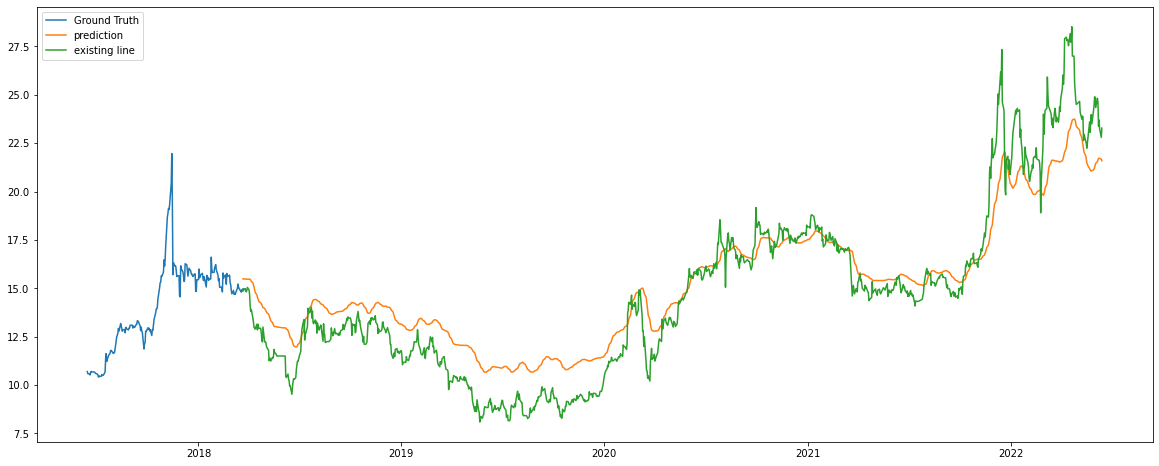

In [46]:
plt.figure(figsize=(20,8))

train_data=data[:205]
valid_data=data[200:]
valid_data['Predictions']=predicted_stock_price
plt.plot(train_data["Adj Close"], label="Ground Truth")
plt.plot(valid_data[["Predictions"]], label="prediction")
plt.plot(valid_data[["Adj Close"]], label="existing line")
plt.legend(loc='upper left')
